In [1]:
# 재현성 함수 및 적용
import os, random, numpy as np
try:
    import torch
except ImportError:
    torch = None

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    if torch is not None:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
            # 재현성 ↔ 성능 트레이드오프: 멘토 코드 기준으로 설정
            torch.backends.cudnn.deterministic = False
            torch.backends.cudnn.benchmark = True

set_seed(42)
print('Seed fixed to 42')

Seed fixed to 42


In [ ]:
try:
    if 'img_files' in globals() and isinstance(img_files, (list, tuple)):
        img_files = sorted(img_files)
    if 'label_files' in globals() and isinstance(label_files, (list, tuple)):
        label_files = sorted(label_files)
    print(f"Deterministic ordering applied: imgs={len(img_files) if 'img_files' in globals() else 0}, labels={len(label_files) if 'label_files' in globals() else 0}")
except Exception as e:
    print('Sorting skipped (no file lists yet):', e)

Deterministic ordering applied: imgs=0, labels=0


In [3]:
import matplotlib.pyplot as plt

# 윈도우
plt.rc('font', family='Malgun Gothic') 
plt.rc('axes', unicode_minus=False)

In [31]:
"""

일단 베이스 EDA 코드에서 작업을 진행하였습니다.
좀더 디테일한 EDA와 전처리 작업을 위해 내용 추가를 주로 진행하였으니
참고하시고 작업 이어가시기 바랍니다.
"""

'\n\n일단 베이스 EDA 코드에서 작업을 진행하였습니다.\n좀더 디테일한 EDA와 전처리 작업을 위해 내용 추가를 주로 진행하였으니\n참고하시고 작업 이어가시기 바랍니다.\n'

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import glob
from collections import Counter

"""
JSON 파일이 아닌 txt 파일을 직접 받았기 때문에 경로가 변경되었습니다.
데이터를 다시 불러왔으므로, 코드가 수정된 부분이 있으니 참고 부탁드리겠습니다.

또한 파일 경로는 상대경로로 되어 있습니다.

"""
# 경로 설정
# data_yolo를 기준으로 경로를 수정
origin_dir = '../data/data_yolo'
img_dir = os.path.join(origin_dir, 'images')
label_dir = os.path.join(origin_dir, 'labels')

# 이미지  불러오기 (하위 폴더 포함) ---
img_files = []
for root, _, files in os.walk(img_dir):
    for f in files:
        if f.endswith(('.png', '.jpg', '.jpeg')):
            img_files.append(os.path.join(root, f))

label_files = []
for root, _, files in os.walk(label_dir):
    for f in files:
        if f.endswith('.txt'):
            label_files.append(os.path.join(root, f))

print("총 이미지 개수:", len(img_files))
print("총 라벨 개수:", len(label_files))
print("샘플 이미지:", img_files[:3])
print("샘플 라벨:", label_files[:3])

# 라벨(txt) 파싱 함수
def parse_yolo_label(label_file):
    boxes = []
    with open(label_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        try:
            class_id, x, y, w, h = map(float, line.strip().split())
            boxes.append([int(class_id), x, y, w, h])
        except ValueError:
            print(f"경고: {label_file} 파일의 라인 파싱 오류: '{line.strip()}'")
    return boxes

# 샘플 라벨 확인
if not label_files:
    raise FileNotFoundError(f"라벨 파일이 없습니다. 경로를 확인하세요: {label_dir}")

sample_label = label_files[0]
boxes = parse_yolo_label(sample_label)
df = pd.DataFrame(boxes, columns=['class_id', 'x_center', 'y_center', 'width', 'height'])
print("\\n--- 샘플 라벨 분석 ---")
print("파일:", sample_label)
print(df.head())

총 이미지 개수: 1489
총 라벨 개수: 1489
샘플 이미지: ['../data/data_yolo\\images\\train\\K-001900-010224-016551-031705_0_2_0_2_75_000_200.png', '../data/data_yolo\\images\\train\\K-001900-010224-016551-031705_0_2_0_2_90_000_200.png', '../data/data_yolo\\images\\train\\K-001900-010224-016551-033009_0_2_0_2_70_000_200.png']
샘플 라벨: ['../data/data_yolo\\labels\\train\\K-001900-010224-016551-031705_0_2_0_2_75_000_200.txt', '../data/data_yolo\\labels\\train\\K-001900-010224-016551-031705_0_2_0_2_90_000_200.txt', '../data/data_yolo\\labels\\train\\K-001900-010224-016551-033009_0_2_0_2_70_000_200.txt']
\n--- 샘플 라벨 분석 ---
파일: ../data/data_yolo\labels\train\K-001900-010224-016551-031705_0_2_0_2_75_000_200.txt
   class_id  x_center  y_center     width    height
0         0  0.231557  0.259375  0.200820  0.115625
1         1  0.259221  0.700000  0.295082  0.387500


### 클래스 개수 및 bbox 평균

In [5]:
import numpy as np
from collections import Counter

"""
내용의 큰 변화는 없으나, 이미지 파일의 경로가 변경되어 코드가 약간 수정 되었음을 주석 달아드립니다.

"""


#  모든 라벨 파일에서 클래스와 바운딩 박스 정보 추출 
all_classes = []
all_boxes = []

for label_file in label_files:
    boxes = parse_yolo_label(label_file)
    for b in boxes:
        all_classes.append(b[0]) # class_id
        all_boxes.append(b[1:])   # x, y, w, h

#  클래스 분포 확인 
if not all_classes:
    raise ValueError("라벨 파일에서 클래스 정보를 찾을 수 없습니다.")

cls_counter = Counter(all_classes)
print("--- 클래스 분포 ---")
print("총 클래스 종류:", len(cls_counter))
print("상위 10개 클래스:", cls_counter.most_common(10))

#  바운딩 박스 크기 분포 확인
if not all_boxes:
    raise ValueError("라벨 파일에서 바운딩 박스 정보를 찾을 수 없습니다.")

widths = [b[2] for b in all_boxes]   
heights = [b[3] for b in all_boxes]  

print("\\n--- 바운딩 박스 크기 분포 (상대 좌표) ---")
print(f"평균 너비: {np.mean(widths):.4f}")
print(f"평균 높이: {np.mean(heights):.4f}")

--- 클래스 분포 ---
총 클래스 종류: 73
상위 10개 클래스: [(50, 514), (29, 240), (0, 180), (15, 172), (4, 143), (1, 139), (38, 113), (37, 111), (31, 109), (32, 108)]
\n--- 바운딩 박스 크기 분포 (상대 좌표) ---
평균 너비: 0.2657
평균 높이: 0.2256


Unique Size 확인

In [6]:
from PIL import Image
from collections import Counter
import os

"""
이것 또한 이미지 파일의 경로가 변경되어 코드가 약간 수정 되었음을 주석 달아드립니다.

"""

# --- [1] 모든 이미지 파일에서 크기 정보 추출 ---
sizes = []
for img_file in img_files:
    try:
        with Image.open(img_file) as img:
            sizes.append(img.size)  # (width, height)
    except Exception as e:
        print(f"경고: {img_file} 파일을 여는 중 오류 발생: {e}")

# --- [2] 유니크한 사이즈 종류 확인 ---
if not sizes:
    raise ValueError("이미지 파일에서 크기 정보를 읽을 수 없습니다.")

unique_sizes = Counter(sizes)

print("--- 이미지 크기 분석 ---")
print('총 분석 이미지 개수:', len(sizes))
print('유니크 사이즈 개수:', len(unique_sizes))
print('상위 10개 사이즈 (너비, 높이):', unique_sizes.most_common(10))

--- 이미지 크기 분석 ---
총 분석 이미지 개수: 1489
유니크 사이즈 개수: 1
상위 10개 사이즈 (너비, 높이): [((976, 1280), 1489)]


### bbox 시각화

yolo_data.yaml 사용 경로: ..\configs\yolo_data.yaml
--- Bbox 시각화 ---
이미지: ../data/data_yolo\images\val\K-003351-018147-021325_0_2_0_2_90_000_200.png
라벨: ../data/data_yolo\labels\val\K-003351-018147-021325_0_2_0_2_90_000_200.txt


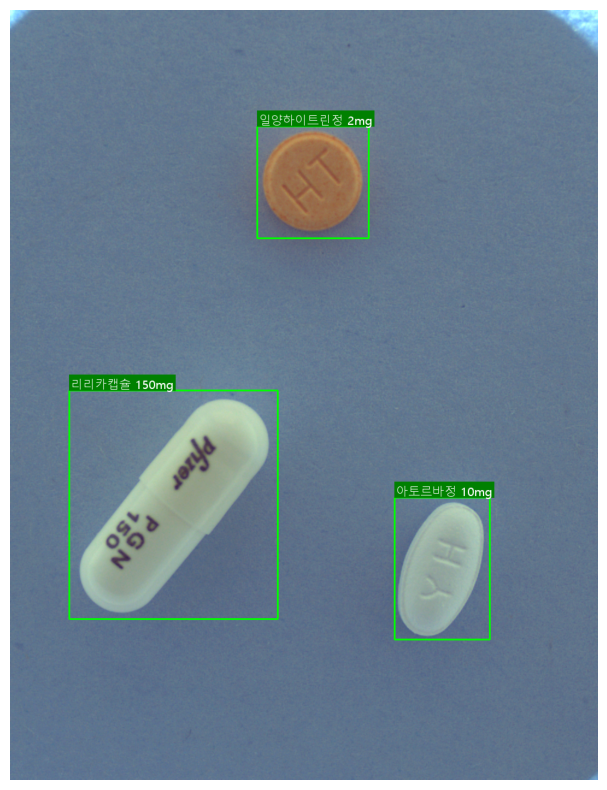

In [7]:
import random
import cv2
import yaml
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont


"""
기존에 있던 yolo_data.yaml 파일을 자동으로 찾아서 클래스 이름을 매핑 했습니다.

이미지에 알약 이름이 출력되도록 폰트를 설정하였고,  OpenCV에서 PIL로 변경하여 한글이 잘 보이도록 수정했습니다.
또한 윈도우/한글 경로 안전을 위해 imdecode 방식을 사용하고, 라벨 경로는 basename 인덱스를 이용해 보강했습니다.
"""

#  yolo_data.yaml
def find_yaml_path(filename='yolo_data.yaml'):
    # 우선 후보 경로들 확인
    candidates = [
        os.path.join('..', 'configs', filename),
        os.path.join('.', 'configs', filename),
        filename,
    ]
    for c in candidates:
        if os.path.exists(c):
            return c
    # 그래도 못 찾으면 현재 경로와 상위 경로에서 재귀 탐색
    for start in [os.getcwd(), os.path.abspath(os.path.join(os.getcwd(), '..'))]:
        for root, _, files in os.walk(start):
            if filename in files:
                return os.path.join(root, filename)
    return None

yaml_path = find_yaml_path()
class_names_list = []
class_names_dict = {}
if yaml_path:
    try:
        with open(yaml_path, 'r', encoding='utf-8') as f:
            data_yaml = yaml.safe_load(f)
            names = data_yaml.get('names', [])
            if isinstance(names, dict):
                class_names_dict = {int(k): v for k, v in names.items()}
            elif isinstance(names, list):
                class_names_list = names
            else:
                print("경고: yaml의 'names' 형식을 인식하지 못했습니다. 클래스 ID로 표시됩니다.")
        print(f"yolo_data.yaml 사용 경로: {yaml_path}")
    except Exception as e:
        print(f"경고: {yaml_path} 파일 로딩 중 오류: {e}")
else:
    print("경고: yolo_data.yaml 파일을 찾지 못했습니다. 클래스 ID로 표시됩니다.")

def get_class_name(cid: int) -> str:
    if class_names_dict:
        return class_names_dict.get(cid, str(cid))
    if class_names_list and 0 <= cid < len(class_names_list):
        return class_names_list[cid]
    return str(cid)

# --- [2] 샘플 이미지 및 라벨 선택 ---
if not img_files:
    raise FileNotFoundError("이미지 파일이 없습니다.")

sample_img_path = random.choice(img_files)
# 이미지 이름에 맞는 라벨 파일 찾기 
fname = os.path.splitext(os.path.basename(sample_img_path))[0]
sample_label_path = os.path.join(label_dir, os.path.relpath(os.path.dirname(sample_img_path), img_dir), f"{fname}.txt")
label_index = {os.path.splitext(os.path.basename(p))[0]: p for p in label_files}
if not os.path.exists(sample_label_path):
    sample_label_path = label_index.get(fname, sample_label_path)

# --- [3] 이미지 및 라벨 로드 ---
img = cv2.imdecode(np.fromfile(sample_img_path, dtype=np.uint8), cv2.IMREAD_COLOR)
if img is None:
    raise FileNotFoundError(f"이미지 파일을 로드할 수 없습니다: {sample_img_path}")
    
if not os.path.exists(sample_label_path):
    print(f"경고: 라벨 파일을 찾을 수 없습니다: {sample_label_path}")
    boxes = []
else:
    boxes = parse_yolo_label(sample_label_path)

# --- [4] 바운딩 박스 시각화 ---
h, w, _ = img.shape

# 먼저 OpenCV로 박스만 그리기
for box in boxes:
    class_id, x_center, y_center, width, height = box
    x1 = int((x_center - width / 2) * w)
    y1 = int((y_center - height / 2) * h)
    x2 = int((x_center + width / 2) * w)
    y2 = int((y_center + height / 2) * h)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# OpenCV(BGR) -> PIL(RGB)로 변환 후 한글 폰트로 텍스트 그리기
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pil_img = Image.fromarray(img_rgb)
draw = ImageDraw.Draw(pil_img)

def load_font(size=20):
    candidates = [
        r"C:\\Windows\\Fonts\\malgun.ttf",
        r"C:\\Windows\\Fonts\\malgunbd.ttf",
        r"C:\\Windows\\Fonts\\arial.ttf",
    ]
    for p in candidates:
        if os.path.exists(p):
            try:
                return ImageFont.truetype(p, size)
            except Exception:
                continue
    return ImageFont.load_default()

font = load_font(20)

for box in boxes:
    class_id, x_center, y_center, width, height = box
    x1 = int((x_center - width / 2) * w)
    y1 = int((y_center - height / 2) * h)
    x2 = int((x_center + width / 2) * w)
    y2 = int((y_center + height / 2) * h)
    label = get_class_name(int(class_id))
    # 텍스트 배경 박스 크기 계산
    try:
        bbox = draw.textbbox((0, 0), label, font=font)
        tw, th = bbox[2] - bbox[0], bbox[3] - bbox[1]
    except Exception:
        tw, th = draw.textlength(label, font=font), 20
    tx, ty = x1, max(0, y1 - th - 4)
    # 텍스트 배경(가독성용)
    draw.rectangle([tx, ty, tx + tw + 6, ty + th + 4], fill=(0, 128, 0))
    # 텍스트
    draw.text((tx + 3, ty + 2), label, font=font, fill=(255, 255, 255))

# PIL -> numpy(RGB)로 변환하여 표시
out_img = np.array(pil_img)

# --- [5] 결과 출력 ---
print("--- Bbox 시각화 ---")
print("이미지:", sample_img_path)
print("라벨:", sample_label_path)
plt.figure(figsize=(10, 10))
plt.imshow(out_img)
plt.axis('off')
plt.show()

### 클래스 분포 확인
편향된 데이터로 생각됨

yolo_data.yaml 사용 경로: ..\configs\yolo_data.yaml
--- 클래스 분포 시각화 (이름 표시) ---


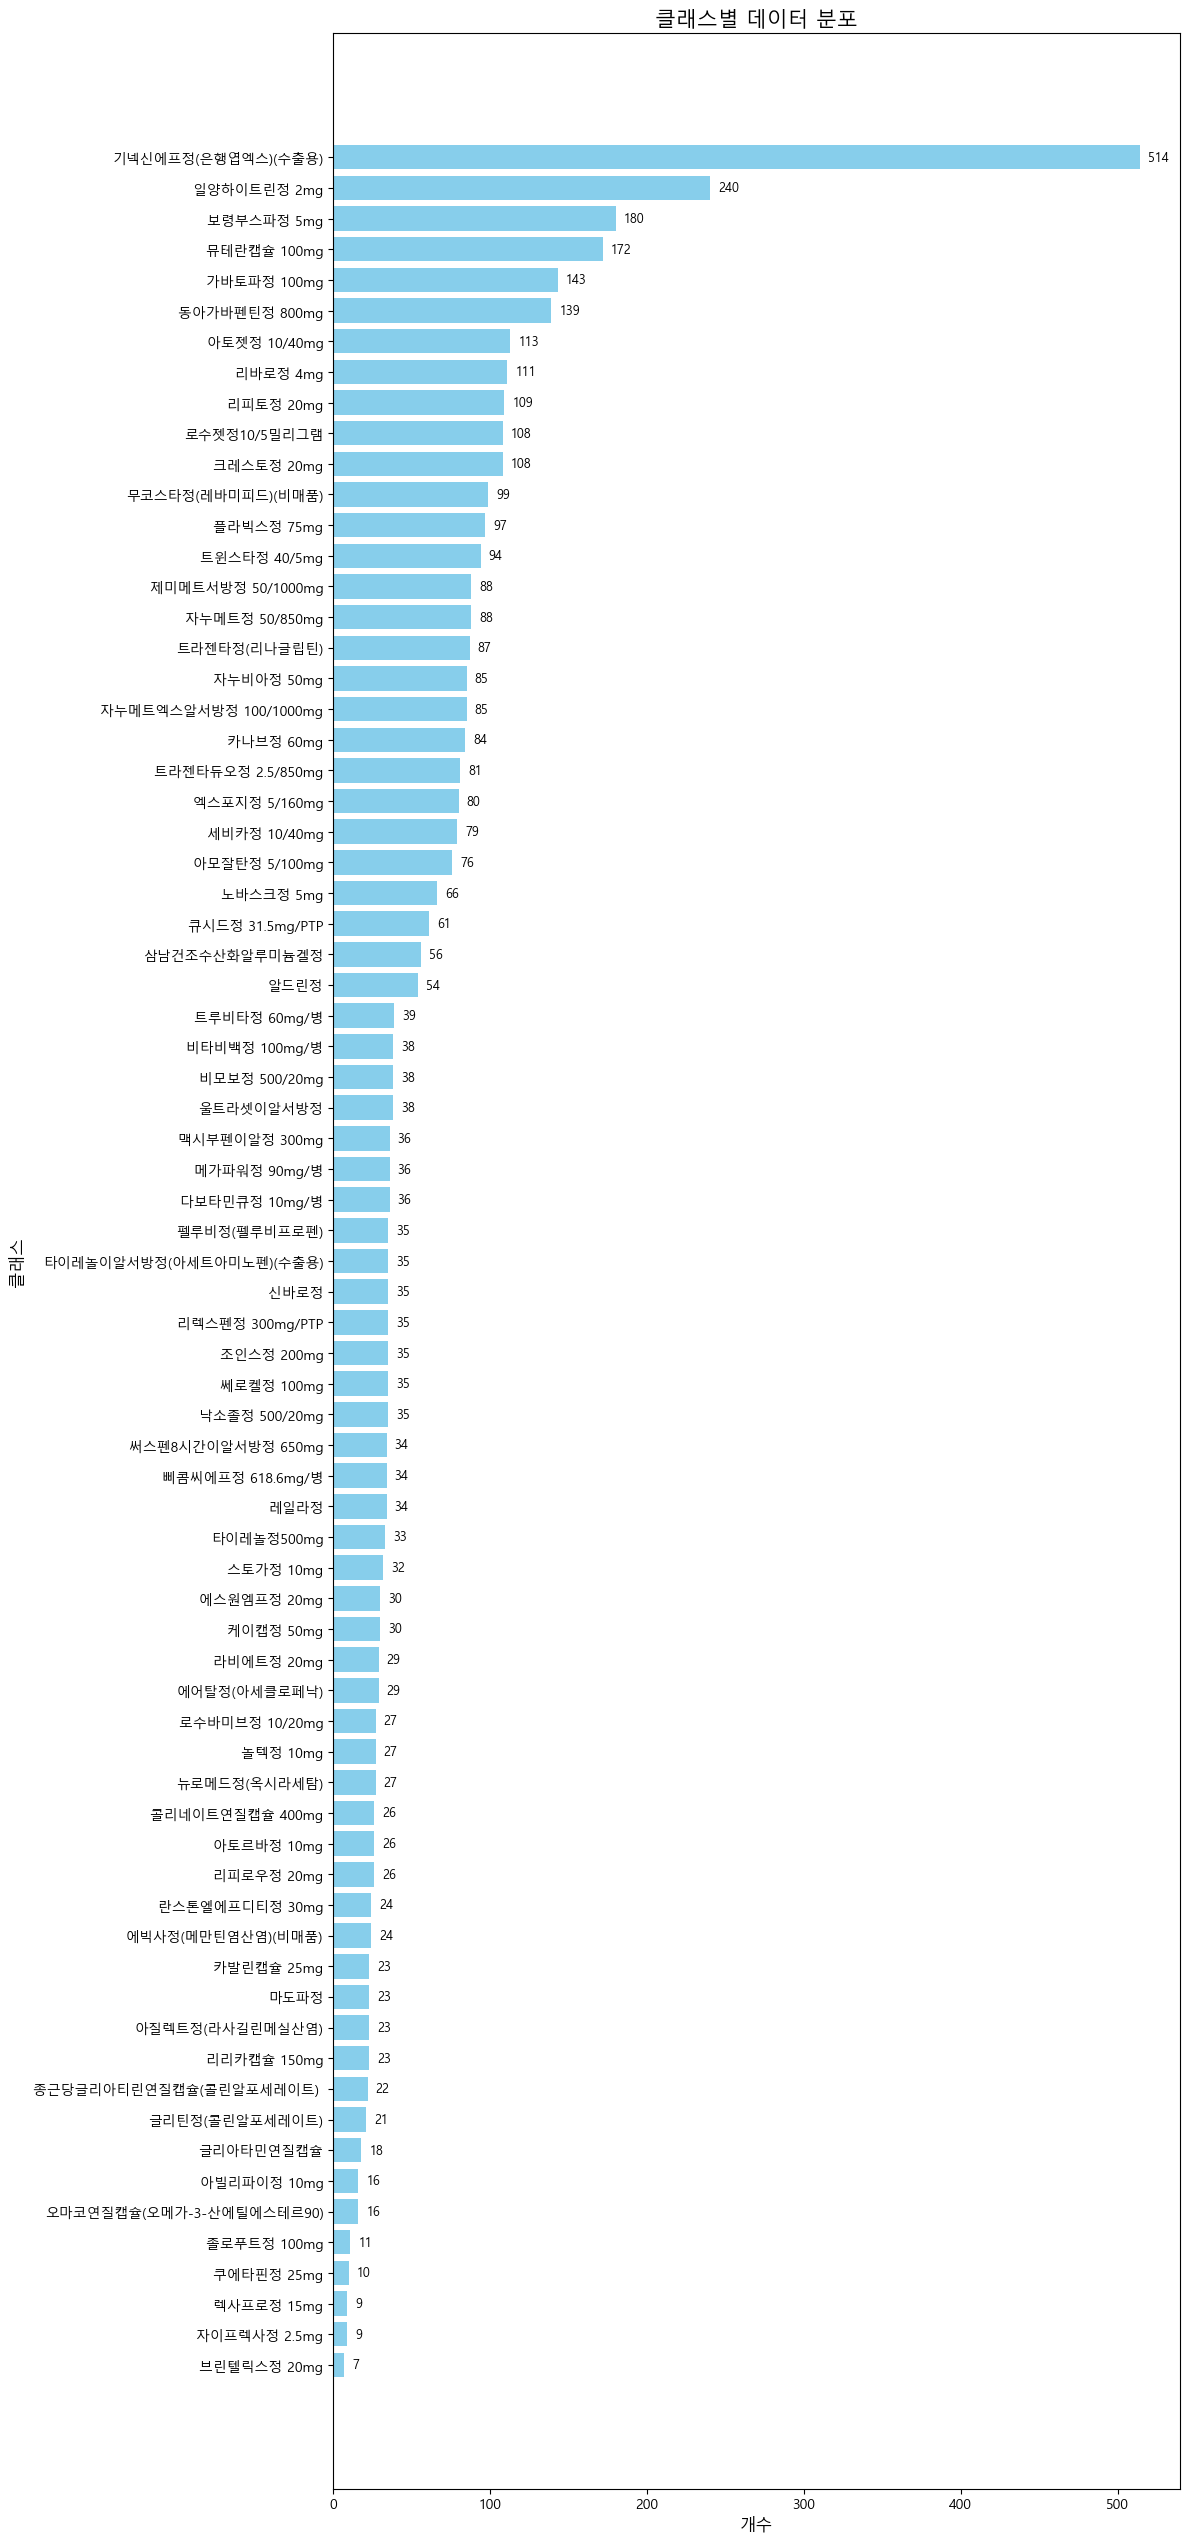

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import os

# --- [0] all_classes 없으면 라벨에서 자동 복원 ---
if 'all_classes' not in globals() or not isinstance(all_classes, (list, tuple)) or len(all_classes) == 0:
    try:
        tmp_classes = []
        for lf in label_files:
            for line in open(lf, 'r', encoding='utf-8').read().splitlines():
                if not line.strip():
                    continue
                try:
                    cls_id = int(float(line.split()[0]))
                    tmp_classes.append(cls_id)
                except Exception:
                    pass
        all_classes = tmp_classes
        print(f"info: 라벨에서 all_classes를 복원했습니다. 총 {len(all_classes)}개 항목")
    except Exception as e:
        print(f"경고: all_classes 복원 실패: {e}")
        all_classes = []

# --- [1] yolo_data.yaml 자동 탐색 (list/dict 모두 지원) ---
def find_yaml_path(filename='yolo_data.yaml'):
    candidates = [
        os.path.join('..', 'configs', filename),
        os.path.join('.', 'configs', filename),
        filename,
    ]
    for c in candidates:
        if os.path.exists(c):
            return c
    for start in [os.getcwd(), os.path.abspath(os.path.join(os.getcwd(), '..'))]:
        for root, _, files in os.walk(start):
            if filename in files:
                return os.path.join(root, filename)
    return None

yaml_path = find_yaml_path()
class_names_list = []
class_names_dict = {}
if yaml_path:
    try:
        with open(yaml_path, 'r', encoding='utf-8') as f:
            data_yaml = yaml.safe_load(f)
            names = data_yaml.get('names', [])
            if isinstance(names, dict):
                class_names_dict = {int(k): v for k, v in names.items()}
            elif isinstance(names, list):
                class_names_list = names
            else:
                print("경고: yaml의 'names' 형식을 인식하지 못했습니다. ID로 표시됩니다.")
        print(f"yolo_data.yaml 사용 경로: {yaml_path}")
    except Exception as e:
        print(f"경고: {yaml_path} 파일 로딩 중 오류: {e}")
else:
    print("경고: yolo_data.yaml 파일을 찾지 못했습니다. 클래스 ID로 표시됩니다.")

def get_class_name(cid: int) -> str:
    if class_names_dict:
        return class_names_dict.get(cid, str(cid))
    if class_names_list and 0 <= cid < len(class_names_list):
        return class_names_list[cid]
    return str(cid)

# --- [2] 클래스 분포 집계 ---
if not all_classes:
    raise ValueError("클래스 데이터가 없습니다. 이전 셀을 먼저 실행하세요.")

named_classes = [get_class_name(cid) for cid in all_classes]
df_classes = pd.DataFrame(named_classes, columns=['class_name'])
class_counts = df_classes['class_name'].value_counts().sort_values(ascending=True)  # 오름차순 정렬

# --- [3] 막대 그래프 시각화 (이름 + 개수 라벨) ---
print("--- 클래스 분포 시각화 (이름 표시) ---")
fig_height = max(6, len(class_counts) * 0.35)
plt.figure(figsize=(12, fig_height))
bars = plt.barh(class_counts.index, class_counts.values, color='skyblue')
plt.xlabel('개수', fontsize=12)
plt.ylabel('클래스', fontsize=12)
plt.title('클래스별 데이터 분포', fontsize=15)

# 각 막대 오른쪽에 개수(값) 표시
max_val = class_counts.values.max() if len(class_counts) else 0
offset = max(1, max_val * 0.01)
for bar, value in zip(bars, class_counts.values):
    width = float(value)
    plt.text(width + offset,
             bar.get_y() + bar.get_height() / 2,
             f'{int(width)}',
             ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 알드린정 & 삼남건조수산화알루미늄겔정 구분 개선 (선명도)

In [9]:
#  저선명 TOP N 식별
import numpy as np, cv2, pandas as pd, os
from tqdm import tqdm

# 블러 스코어 계산 함수 
def blur_score(img_path: str) -> float:
    try:
        img = cv2.imdecode(np.fromfile(img_path, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)
        if img is None: return np.nan
        return float(cv2.Laplacian(img, cv2.CV_64F).var())
    except Exception:
        return np.nan

N = 30  # 하위 N
scores = []
for p in tqdm(img_files, desc='Blur scoring'):
    s = blur_score(p)
    scores.append((p, s))

df_blur2 = pd.DataFrame(scores, columns=['img','blur'])
valid = df_blur2['blur'].dropna()
print(f"유효 블러 스코어 이미지: {len(valid)} / 전체 {len(df_blur2)}")
if len(valid):
    print('분위수(5,25,50,75,95):', np.percentile(valid, [5,25,50,75,95]))
lowN = df_blur2.nsmallest(N, 'blur')
lowN

Blur scoring: 100%|██████████| 1489/1489 [00:41<00:00, 35.79it/s]

유효 블러 스코어 이미지: 1489 / 전체 1489
분위수(5,25,50,75,95): [27.24921932 34.71939597 37.61575947 44.75930456 50.32876168]


,img,blur
350,../data/data_yolo\images\train\K-002483-013395...,24.515937
339,../data/data_yolo\images\train\K-002483-012081...,24.557045
1275,../data/data_yolo\images\val\K-002483-013395-0...,24.623030
347,../data/data_yolo\images\train\K-002483-013395...,24.676366
324,../data/data_yolo\images\train\K-002483-006192...,24.875536
1273,../data/data_yolo\images\val\K-002483-012778-0...,24.909366
356,../data/data_yolo\images\train\K-002483-022362...,24.953268
333,../data/data_yolo\images\train\K-002483-012081...,24.965785
336,../data/data_yolo\images\train\K-002483-012081...,25.067960
321,../data/data_yolo\images\train\K-002483-005886...,25.087030


타겟 매칭된 클래스:
0 보령부스파정 5mg
1 동아가바펜틴정 800mg
2 낙소졸정 500/20mg
3 신바로정
4 가바토파정 100mg
5 란스톤엘에프디티정 30mg
6 펠루비정(펠루비프로펜)
7 울트라셋이알서방정
8 비모보정 500/20mg
9 레일라정
10 스토가정 10mg
11 라비에트정 20mg
12 놀텍정 10mg
13 에스원엠프정 20mg
14 케이캡정 50mg
16 알드린정
17 타이레놀정500mg
18 삐콤씨에프정 618.6mg/병
19 다보타민큐정 10mg/병
20 트루비타정 60mg/병
21 메가파워정 90mg/병
22 비타비백정 100mg/병
23 타이레놀이알서방정(아세트아미노펜)(수출용)
24 리렉스펜정 300mg/PTP
25 써스펜8시간이알서방정 650mg
26 맥시부펜이알정 300mg
27 삼남건조수산화알루미늄겔정
28 큐시드정 31.5mg/PTP
29 일양하이트린정 2mg
30 뉴로메드정(옥시라세탐)
31 리피토정 20mg
32 크레스토정 20mg
34 플라빅스정 75mg
35 아토르바정 10mg
36 리피로우정 20mg
37 리바로정 4mg
38 아토젯정 10/40mg
39 로수젯정10/5밀리그램
40 로수바미브정 10/20mg
41 에빅사정(메만틴염산염)(비매품)
45 마도파정
46 아질렉트정(라사길린메실산염)
48 글리틴정(콜린알포세레이트)
50 기넥신에프정(은행엽엑스)(수출용)
51 노바스크정 5mg
52 자누비아정 50mg
53 트라젠타정(리나글립틴)
54 트라젠타듀오정 2.5/850mg
55 자누메트엑스알서방정 100/1000mg
56 제미메트서방정 50/1000mg
57 엑스포지정 5/160mg
58 자누메트정 50/850mg
59 아모잘탄정 5/100mg
60 세비카정 10/40mg
61 트윈스타정 40/5mg
62 카나브정 60mg
63 무코스타정(레바미피드)(비매품)
64 에어탈정(아세클로페낙)
65 쎄로켈정 100mg
66 아빌리파이정 10mg
67 자이프렉사정 2.5mg
68 쿠에타핀정 25mg
69 졸로푸트

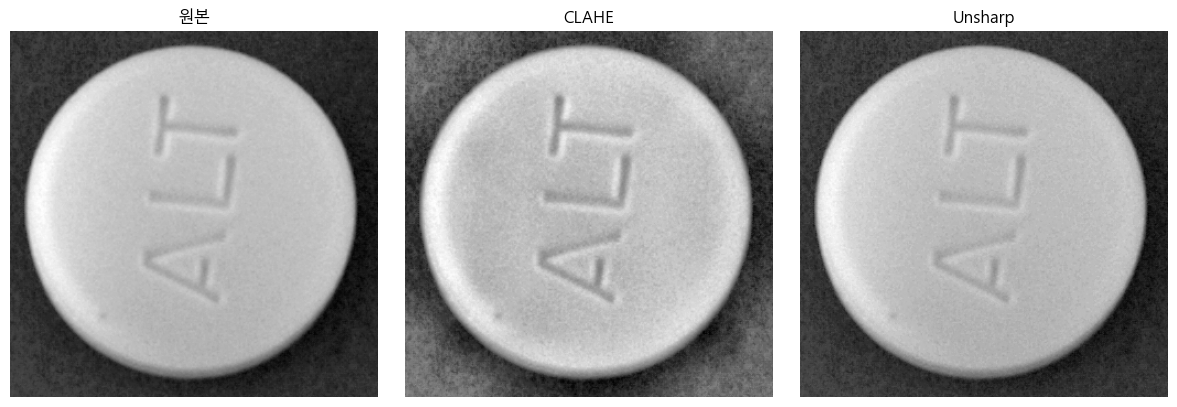

In [10]:
#  CLAHE/샤프닝 전후 비교 

"""

이미지와 크기가 거의 비슷하여 인식을 잘 못하는 것 같아보였습니다.
블러 스코어가 낮은 이미지 중 하나를 골라서 CLAHE와 샤프닝을 적용시켜봤습니다.
해당 타겟 클래스 박스가 실제로 포함된 이미지로만 구성하도록 했습니다.

"""

import cv2, numpy as np, random, os, matplotlib.pyplot as plt
from collections import defaultdict

def paired_label_path(img_path: str) -> str:
    fname = os.path.splitext(os.path.basename(img_path))[0]
    return os.path.join(label_dir, os.path.relpath(os.path.dirname(img_path), img_dir), f"{fname}.txt")

def load_boxes(lp):
    if not os.path.exists(lp): return []
    out=[]
    for line in open(lp,'r',encoding='utf-8',errors='ignore').read().splitlines():
        if not line.strip(): continue
        try:
            cid,x,y,w,h = map(float, line.split())
            out.append((int(cid),x,y,w,h))
        except:
            pass
    return out

def yolo_crop(img, b):
    h,w = img.shape[:2]
    _,xc,yc,bw,bh = b
    x1 = max(0, int((xc-bw/2)*w)); y1 = max(0, int((yc-bh/2)*h))
    x2 = min(w, int((xc+bw/2)*w)); y2 = min(h, int((yc+bh/2)*h))
    return img[y1:y2, x1:x2]

def clahe(gray):
    return cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(gray)

def unsharp(img_gray):
    blur = cv2.GaussianBlur(img_gray, (0,0), 1.0)  # sigma=1.0
    sharp = cv2.addWeighted(img_gray, 1.5, blur, -0.5, 0)
    return np.clip(sharp, 0, 255).astype(np.uint8)

# 클래스 이름 → ID 추출 (부분 문자열 매칭)
def get_class_name(cid: int) -> str:
    if 'class_names_dict' in globals() and class_names_dict:
        return class_names_dict.get(cid, str(cid))
    if 'class_names_list' in globals() and class_names_list and 0 <= cid < len(class_names_list):
        return class_names_list[cid]
    return str(cid)

# 라벨 내 등장 클래스 수집
cls_counts = defaultdict(int)
for lf in label_files:
    for line in open(lf,'r',encoding='utf-8',errors='ignore').read().splitlines():
        if not line.strip(): continue
        try:
            cid = int(float(line.split()[0]))
            cls_counts[cid] += 1
        except:
            pass

# 타겟 이름(부분 문자열) 정의
target_substrings = ["알드린정", "삼남", "알루미늄", "정"]  # 삼남간조수산화알루미늄정을 포괄하는 키워드 포함
prefer_pairs = ["알드린정", "삼남간조수산화알루미늄정"]  # 보고용 출력

target_ids = set()
for cid in sorted(cls_counts.keys()):
    name = get_class_name(cid)
    if any(sub in str(name) for sub in target_substrings):
        target_ids.add(cid)

print("타겟 매칭된 클래스:")
for cid in sorted(target_ids):
    print(cid, get_class_name(cid))
if not target_ids:
    raise RuntimeError("타겟 클래스에 매칭되는 ID를 찾지 못했습니다. yaml names를 확인하세요.")

# 후보 이미지 수집: 반드시 타겟 클래스 박스가 있어야 함 
label_index = {os.path.splitext(os.path.basename(p))[0]: p for p in label_files}
cands = []  # (img_path, [target_boxes])
for ip in img_files:
    bn = os.path.splitext(os.path.basename(ip))[0]
    lp = label_index.get(bn)
    if not lp or not os.path.exists(lp):
        continue
    boxes = load_boxes(lp)
    tboxes = [b for b in boxes if b[0] in target_ids]
    if tboxes:
        cands.append((ip, tboxes))

# 저선명 목록과 교집합 우선
try:
    low_blur_set = set([p for p in df_blur2.nsmallest(200,'blur')['img'].tolist() if os.path.exists(p)])
    cands_low = [(ip, tbs) for ip, tbs in cands if ip in low_blur_set]
    if cands_low:
        cands = cands_low
except Exception:
    pass

if not cands:
    raise RuntimeError('타겟 클래스가 포함된 후보 이미지를 찾지 못했습니다.')

#  무작위 선택 후 해당 클래스 박스로 크롭
ip, tboxes = random.choice(cands)
img = cv2.imdecode(np.fromfile(ip, dtype=np.uint8), cv2.IMREAD_COLOR)
if img is None:
    raise RuntimeError('이미지 로드 실패')
box_sel = random.choice(tboxes)  # 타겟 박스 중 하나 선택

crop = yolo_crop(img, box_sel)
if crop.size==0:
    raise RuntimeError('크롭 실패')
gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
enh1 = clahe(gray)
enh2 = unsharp(gray)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title('원본'); plt.imshow(gray, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('CLAHE'); plt.imshow(enh1, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('Unsharp'); plt.imshow(enh2, cmap='gray'); plt.axis('off')
plt.tight_layout(); plt.show()

## 타겟 클래스 구분 개선: 타이레놀이알서방정 vs 써스펜8시간이알서방정



In [11]:
# 타겟 클래스 ID 자동 탐색
import os, yaml
from collections import defaultdict

# 클래스 이름 사전 로딩 (앞 셀과 변수 공유)
def get_class_name(cid: int) -> str:
    if 'class_names_dict' in globals() and class_names_dict:
        return class_names_dict.get(cid, str(cid))
    if 'class_names_list' in globals() and class_names_list and 0 <= cid < len(class_names_list):
        return class_names_list[cid]
    return str(cid)

# 라벨내 등장 클래스 집계
cls_counts = defaultdict(int)
for lf in label_files:
    for line in open(lf,'r',encoding='utf-8',errors='ignore').read().splitlines():
        if not line.strip(): continue
        try:
            cid = int(float(line.split()[0]))
            cls_counts[cid] += 1
        except:
            pass

# 사용자가 관심 가진 두 이름
target_names = ["타이레놀이알서방정(아세트아미노펜)(수출용)", "써스펜8시간이알서방정"]

# 이름→ID 역매핑 후보 만들기
name_to_ids = defaultdict(list)
for cid in sorted(cls_counts.keys()):
    name_to_ids[get_class_name(cid)].append(cid)

print("--- 후보 클래스 ID (이름 → IDS) ---")
for n in target_names:
    print(f"{n}: ", name_to_ids.get(n, []))
if any(len(name_to_ids.get(n, []))==0 for n in target_names):
    print("경고: 이름이 yaml의 names와 정확히 일치하지 않을 수 있습니다. 유사 이름을 확인하세요.")

--- 후보 클래스 ID (이름 → IDS) ---
타이레놀이알서방정(아세트아미노펜)(수출용):  [23]
써스펜8시간이알서방정:  []
경고: 이름이 yaml의 names와 정확히 일치하지 않을 수 있습니다. 유사 이름을 확인하세요.


In [12]:
# 타겟 클래스 샘플 수집
import os, random, cv2, numpy as np
from collections import defaultdict

# 위 셀에서 name_to_ids가 생성되었다고 가정
def collect_samples_for_ids(target_ids, max_per_class=50):
    # basename → 라벨 파일 경로 매핑
    label_index = {os.path.splitext(os.path.basename(p))[0]: p for p in label_files}
    hits = defaultdict(list)  # cid -> [(img_path, (cid, x,y,w,h)), ...]
    for ip in img_files:
        bn = os.path.splitext(os.path.basename(ip))[0]
        lp = label_index.get(bn)
        if not lp or not os.path.exists(lp):
            continue
        for line in open(lp,'r',encoding='utf-8',errors='ignore').read().splitlines():
            if not line.strip(): continue
            try:
                cid,x,y,w,h = map(float, line.split())
                cid = int(cid)
                if cid in target_ids and len(hits[cid]) < max_per_class:
                    hits[cid].append((ip, (cid,x,y,w,h)))
            except:
                pass
    return hits

# 두 클래스 IDs 확정 (여러 ID가 매핑된다면 첫번째를 우선 사용)
idsA = name_to_ids.get(target_names[0], [])
idsB = name_to_ids.get(target_names[1], [])
idsA = idsA if isinstance(idsA, list) else [idsA]
idsB = idsB if isinstance(idsB, list) else [idsB]
print('IDs A:', idsA)
print('IDs B:', idsB)

hits = collect_samples_for_ids(set(idsA + idsB), max_per_class=60)
print({cid: len(v) for cid,v in hits.items()})

IDs A: [23]
IDs B: []
{23: 35}
{23: 35}


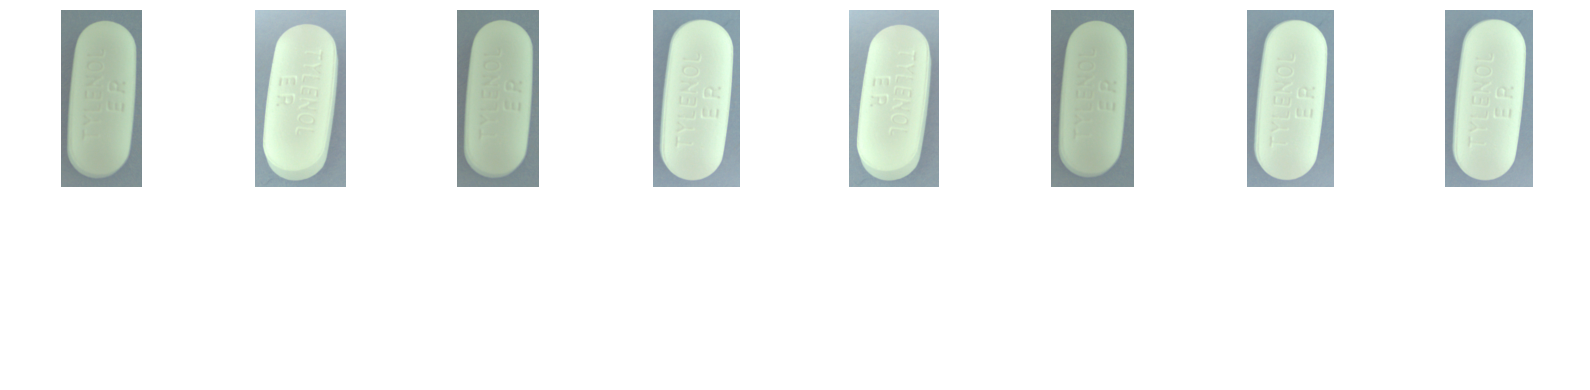

In [13]:
# 두 클래스 비교 갤러리 (썸네일)
import matplotlib.pyplot as plt
import math

def yolo_crop_rgb(img_bgr, box):
    h,w = img_bgr.shape[:2]
    _,xc,yc,bw,bh = box
    x1 = max(0, int((xc-bw/2)*w)); y1 = max(0, int((yc-bh/2)*h))
    x2 = min(w, int((xc+bw/2)*w)); y2 = min(h, int((yc+bh/2)*h))
    crop = img_bgr[y1:y2, x1:x2]
    if crop.size==0:
        return None
    return cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

def gallery_for_class(cid, n=8):
    items = hits.get(cid, [])[:n]
    imgs = []
    for item in items:
        # item should be (ip, box), where box is a tuple/list
        if isinstance(item, (list, tuple)) and len(item) == 2:
            ip, box = item
        else:
            # fallback: skip or handle error
            imgs.append(None)
            continue
        img = cv2.imdecode(np.fromfile(ip, dtype=np.uint8), cv2.IMREAD_COLOR)
        if img is None:
            imgs.append(None)
            continue
        # box should be a tuple/list of 5 elements: (cid, xc, yc, bw, bh)
        if isinstance(box, (list, tuple)) and len(box) >= 5:
            rgb = yolo_crop_rgb(img, box)
        else:
            rgb = None
        imgs.append(rgb)
    return imgs

# 각 클래스에서 최대 8개씩 그리드
n=8
fig, axes = plt.subplots(2, n, figsize=(2*n, 4))
cids = [idsA[0] if idsA else None, idsB[0] if idsB else None]
titles = [target_names[0], target_names[1]]
for row, (cid, title) in enumerate(zip(cids, titles)):
    if cid is None:
        for col in range(n):
            axes[row, col].axis('off')
        axes[row, 0].set_ylabel(title)
        continue
    imgs = gallery_for_class(cid, n=n)
    for col, img_rgb in enumerate(imgs):
        axes[row, col].axis('off')
        if img_rgb is not None:
            axes[row, col].imshow(img_rgb)
    axes[row, 0].set_ylabel(title)
plt.tight_layout(); plt.show()

In [17]:
# 크롭 특징 비교: 선명도/대비 지표
import numpy as np, cv2, pandas as pd

def crop_metrics(img_rgb):
    if img_rgb is None or img_rgb.size==0:
        return None
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    lap_var = float(cv2.Laplacian(gray, cv2.CV_64F).var())
    contrast = float(np.std(gray))
    mean_int = float(np.mean(gray))
    return {'lap_var': lap_var, 'contrast': contrast, 'mean': mean_int}

def sample_metrics(cid, k=30):
    items = hits.get(cid, [])[:k]
    rows = []
    for ip, box in items:
        img = cv2.imdecode(np.fromfile(ip, dtype=np.uint8), cv2.IMREAD_COLOR)
        if img is None:
            continue
        # box는 (cid, xc, yc, bw, bh) 형태의 튜플이어야 함
        rgb = yolo_crop_rgb(img, box) if isinstance(box, (list, tuple)) and len(box) >= 5 else None
        m = crop_metrics(rgb) if rgb is not None else None
        if m:
            m['cid'] = cid
            rows.append(m)
    # 빈 경우에도 고정 스키마 유지
    return pd.DataFrame(rows) if rows else pd.DataFrame(columns=['lap_var','contrast','mean','cid'])

def describe_or_msg(df, label):
    if df is None or df.shape[1] == 0:
        print(f"{label}: 샘플/열 없음")
    elif df.empty:
        # 열은 있으나 행이 없을 때
        try:
            print(f"{label} stats (열만 존재, 행 0):\n", df.describe())
        except Exception as e:
            print(f"{label}: 통계 요약 실패 - {e}")
    else:
        try:
            print(f"{label} stats:\n", df.describe())
        except Exception as e:
            print(f"{label}: 통계 요약 실패 - {e}")

dfA = sample_metrics(idsA[0]) if idsA else pd.DataFrame(columns=['lap_var','contrast','mean','cid'])
dfB = sample_metrics(idsB[0]) if idsB else pd.DataFrame(columns=['lap_var','contrast','mean','cid'])
describe_or_msg(dfA, 'A')
describe_or_msg(dfB, 'B')

A stats:
          lap_var   contrast        mean   cid
count  30.000000  30.000000   30.000000  30.0
mean   23.777378  31.342219  189.760643  23.0
std     4.951324   3.400577   14.800360   0.0
min    15.385042  25.721139  164.710827  23.0
25%    18.576607  27.645743  173.927121  23.0
50%    26.266718  32.190371  197.777599  23.0
75%    26.645773  34.267569  199.530731  23.0
max    28.710318  34.422893  200.385363  23.0
B stats (열만 존재, 행 0):
        lap_var contrast mean  cid
count        0        0    0    0
unique       0        0    0    0
top        NaN      NaN  NaN  NaN
freq       NaN      NaN  NaN  NaN


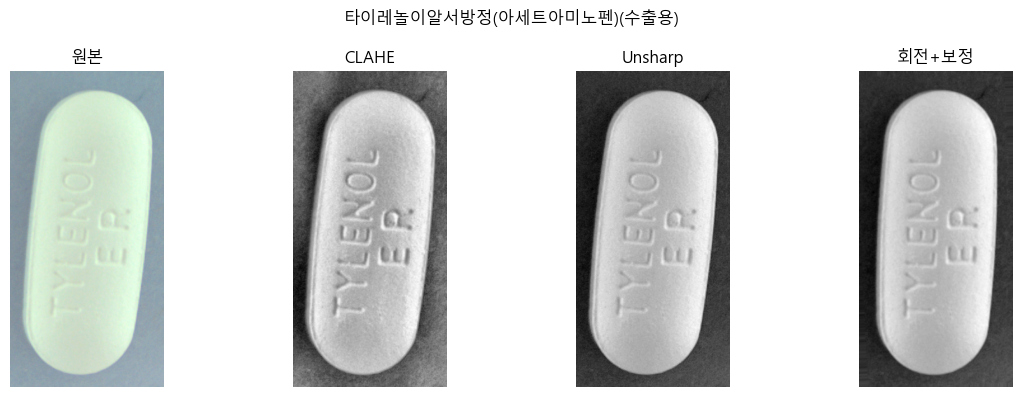

써스펜8시간이알서방정: ID를 찾지 못했습니다.


In [20]:
# CLAHE/Unsharp/회전
import matplotlib.pyplot as plt
def preview_enhance(img_rgb):
    if img_rgb is None:
        return None, None, None
    g = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    cla = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(g)
    blur = cv2.GaussianBlur(g, (0,0), 1.0)
    sharp = cv2.addWeighted(g, 1.5, blur, -0.5, 0)
    # 약간의 회전(텍스트 정렬 보정 가정)
    M = cv2.getRotationMatrix2D((g.shape[1]/2, g.shape[0]/2), 3, 1.0)
    rot = cv2.warpAffine(g, M, (g.shape[1], g.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return cla, sharp, rot

def pick_crop(cid):
    items = hits.get(cid, [])
    if not items: return None
    ip, box = random.choice(items)
    img = cv2.imdecode(np.fromfile(ip, dtype=np.uint8), cv2.IMREAD_COLOR)
    if img is None: return None
    # box는 (cid, xc, yc, bw, bh) 형태의 튜플이어야 함
    return yolo_crop_rgb(img, box) if isinstance(box, (list, tuple)) and len(box) >= 5 else None

for cid, title in [(idsA[0] if idsA else None, target_names[0]), (idsB[0] if idsB else None, target_names[1])]:
    if cid is None:
        print(f"{title}: ID를 찾지 못했습니다.")
        continue
    crop_rgb = pick_crop(cid)
    if crop_rgb is None:
        print(f"{title}: 크롭을 얻지 못했습니다.")
        continue
    cla, sharp, rot = preview_enhance(crop_rgb)
    plt.figure(figsize=(12,4))
    plt.suptitle(title)
    plt.subplot(1,4,1); plt.title('원본'); plt.imshow(crop_rgb); plt.axis('off')
    plt.subplot(1,4,2); plt.title('CLAHE'); plt.imshow(cla, cmap='gray'); plt.axis('off')
    plt.subplot(1,4,3); plt.title('Unsharp'); plt.imshow(sharp, cmap='gray'); plt.axis('off')
    plt.subplot(1,4,4); plt.title('회전+보정'); plt.imshow(rot, cmap='gray'); plt.axis('off')
    plt.tight_layout(); plt.show()

In [ ]:
"""

EDA 방향성을 다시 잡아야할 것 같습니다.

참고만 하시기 바랍니다.

"""